<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-histograms-(or-create-if-needed)" data-toc-modified-id="Load-histograms-(or-create-if-needed)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load histograms (or create if needed)</a></span><ul class="toc-item"><li><span><a href="#Split-NL-band" data-toc-modified-id="Split-NL-band-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split NL band</a></span></li><li><span><a href="#Plot-histograms" data-toc-modified-id="Plot-histograms-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plot histograms</a></span></li></ul></li>

Prerequisites:
1. Run `preprocessing/analyze_tfrecords_dhs.ipynb`.
2. Run `data_analysis/dhs.ipynb` to create the `dhs_loc_dict.pkl` and `dhs_incountry_folds.pkl`.

# Imports and Constants

Downloading Libraries

In [2]:
!pip install matplotlib
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.neighbors

from batchers import batcher1, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from models.linear_model import ridge_cv
from models.knn import knn_cv_opt
from utils.analysis import calc_score, evaluate
from utils.general import load_npz
from utils.plot import scatter_preds


/root/Datasets/SelectedClusters/nexus_tfrecords_processed_new/


Important Constants

In [4]:
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

DATASET_NAME = 'DHS_OOC_A'
LABEL_NAME = 'wealthpooled'

FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
COUNTRIES = dataset_constants.DHS_COUNTRIES
print(COUNTRIES)

MEANS = dataset_constants.MEANS_DICT[DATASET_NAME]
STD_DEVS = dataset_constants.STD_DEVS_DICT[DATASET_NAME]
s = dataset_constants.SURVEY_NAMES[DATASET_NAME]

LOGS_ROOT_DIR = "/root/ModelWorkflow/Logs/04_dhs_baselines/" 
print(LOGS_ROOT_DIR)

['brazil']
/root/ModelWorkflow/Logs/04_dhs_baselines/


# Load histograms (or create if needed)

Constants to Plot the Histograms

In [5]:
# BAND_BIN_EDGES = [-10^5, -5.0, -4.9, -4.8, ..., 4.8, 4.9, 5.0, 10^5]
# BAND_BIN_CENTERS = [-5.05, -4.95, -4.85, ..., 4.85, 4.95, 5.05]
BAND_BIN_EDGES = np.concatenate([
    [-1e5],
    np.arange(-5.0, 5.1, 0.1),
    [1e5]
])
BAND_BIN_CENTERS = np.arange(-5.05, 5.15, 0.1)

# LABEL_BIN_EDGES = [-2.0, -1.9, ..., 2.8, 2.9]
# LABEL_BIN_CENTERS = [-1.95, -1.85, ..., 2.75, 2.85]
LABEL_BIN_EDGES = np.arange(-2.0, 3.0, 0.1)
LABEL_BIN_CENTERS = np.arange(-1.95, 2.95, 0.1)

# band name => color for plotting
BAND_COLORS = {
    'BLUE'  : 'blue',
    'GREEN' : 'green',
    'RED'   : 'red',
    'SWIR1' : 'purple',
    'SWIR2' : 'brown',
    'TEMP1' : 'orange',
    'NIR'   : 'pink',
    'NIGHTLIGHTS': 'black',
    'DMSP'  : 'black',
    'VIIRS' : 'gray',
}
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
BAND_ORDER_NLSPLIT = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'DMSP', 'VIIRS']

BANDS_DICT = {
    'rgb': [0, 1, 2],
    'rgbnl': [0, 1, 2, 7, 8],
    'ms': [0, 1, 2, 3, 4, 5, 6],
    'msnl': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'nl': [7, 8],
}

In [11]:
def get_batcher(tfrecord_files, label):
    if label == "literacy":
        return batcher1.Batcher(
            tfrecord_files=tfrecord_files,
            dataset=DATASET_NAME,
            batch_size=128,
            ls_bands='ms',
            nl_band='merge',
            label_name="literacy",
            shuffle=False,
            augment=False,
            negatives='zero',
            normalize=True)
    
    elif label == "longevity":
        return batcher1.Batcher(
            tfrecord_files=tfrecord_files,
            dataset=DATASET_NAME,
            batch_size=128,
            ls_bands='ms',
            nl_band='merge',
            label_name="longevity",
            shuffle=False,
            augment=False,
            negatives='zero',
            normalize=True)
    else:
        return batcher1.Batcher(
            tfrecord_files=tfrecord_files,
            dataset=DATASET_NAME,
            batch_size=128,
            ls_bands='ms',
            nl_band='merge',
            label_name="income",
            shuffle=False,
            augment=False,
            negatives='zero',
            normalize=True)

Function that Creates the .npz Files - Containing the information to plot the histograms

In [7]:
def generate_image_histogram(label):
    file_path = f"/root/Datasets/SelectedClusters/dhs_co_{label}.npz"
    print(file_path)
    
    if label == "longevity":
        if not os.path.exists(file_path):
            # THIS REQUIRES >= 35 GB RAM
            tfrecord_paths = batcher1.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
            init_iter, batch_op = get_batcher(tfrecord_paths,label).get_batch()
            results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
            print(results)
            print('Saving image histograms to', file_path)
            np.savez_compressed(file_path, **results)
            
    elif label == "literacy":
        if not os.path.exists(file_path):
            # THIS REQUIRES >= 35 GB RAM
            tfrecord_paths = batcher1.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
            init_iter, batch_op = get_batcher(tfrecord_paths,label).get_batch()
            results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
            print(results)
            print('Saving image histograms to', file_path)
            np.savez_compressed(file_path, **results)
    else :       
        if not os.path.exists(file_path):
            # THIS REQUIRES >= 35 GB RAM
            tfrecord_paths = batcher1.get_tfrecord_paths(dataset=DATASET_NAME, split='all')
            init_iter, batch_op = get_batcher(tfrecord_paths,label).get_batch()
            results = get_per_image_histograms(init_iter, batch_op, band_bin_edges=BAND_BIN_EDGES)
            print(results)
            print('Saving image histograms to', file_path)
            np.savez_compressed(file_path, **results)
    

In [8]:
indicators = ["income","longevity","literacy"]
for indicator in indicators:
    generate_image_histogram(indicator)

/root/Datasets/SelectedClusters/dhs_co_income.npz
brazil_2010
20438
20438


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.

Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished b

NameError: name 'batcher1_lon' is not defined

Verifying the .npz files

In [12]:
indicators = ["income","longevity","literacy"]
for label in indicators:
    file_path = f"/root/Datasets/SelectedClusters/dhs_co_{label}.npz"
    print(f"para o Indicador {label}:")
    result = load_npz(file_path)
    image_hists = result['image_hists']
    labels = result['labels']

    locs = result['locs']
    years = result['years']
    nls_center = result["nls_center"]

    nls_mean = result['nls_mean']

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

para o Indicador income:
image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)
[[[0.0000e+00 0.0000e+00 0.0000e+00 ... 3.7000e+01 3.4000e+01 6.0500e+02]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 4.1000e+01 3.4000e+01 4.1900e+02]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 1.3000e+01 1.1000e+01 1.0800e+02]
  ...
  [8.9000e+01 3.9000e+01 2.7000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 5.0176e+04]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 [[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  ...
  [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0

## Split NL band

In [ ]:
indicators = ["income","longevity","literacy"]
for label in indicators:
    file_path = f"/root/Datasets/SelectedClusters/dhs_co_{label}.npz"
    print(f"para o Indicador {label}:")
    result = load_npz(file_path)
    image_hists = result['image_hists']
    labels = result['labels']
    image_hists = split_nl_hist(image_hists, years)
    print(image_hists)
    print(years)

## Plot histograms

para o Indicador income:
image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)


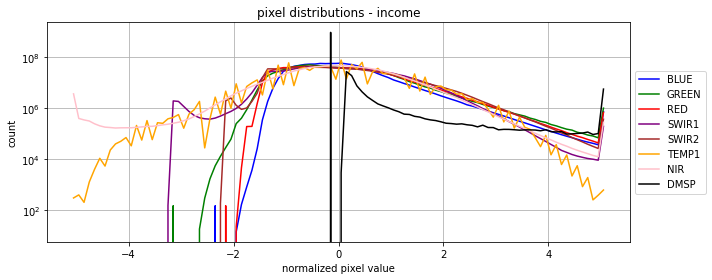

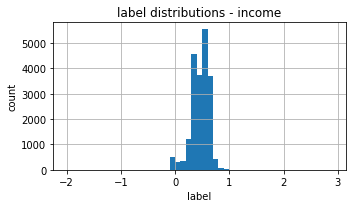

para o Indicador longevity:
image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)


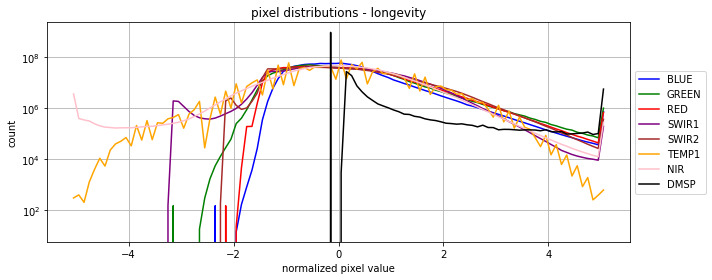

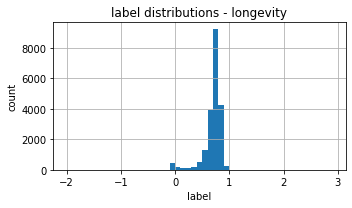

para o Indicador literacy:
image_hists: dtype=int64, shape=(20438, 8, 102)
labels: dtype=float32, shape=(20438,)
locs: dtype=float32, shape=(20438, 2)
years: dtype=int32, shape=(20438,)
nls_center: dtype=float32, shape=(20438,)
nls_mean: dtype=float32, shape=(20438,)


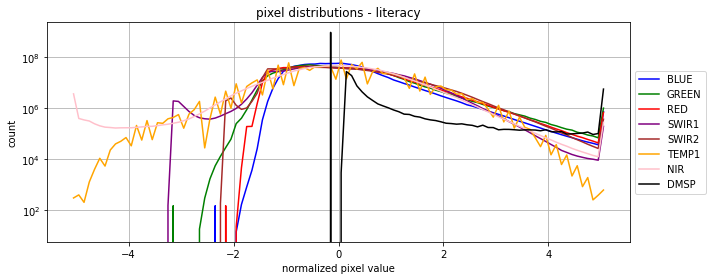

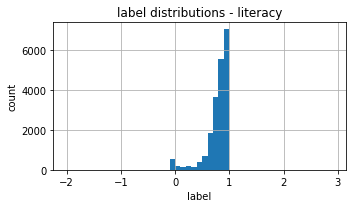

In [13]:
indicators = ["income","longevity","literacy"]
datasets = [2,3,4]
for i,label in enumerate(indicators):
    file_path = f"/root/Datasets/SelectedClusters/dhs_co_{label}.npz"
    print(f"para o Indicador {label}:")
    result = load_npz(file_path)
    
    image_hists = result['image_hists']
    labels = result['labels']

    
    band_hists = np.sum(image_hists, axis=0, dtype=np.int64)  # shape [C, nbins]
    plot_band_hists(
        band_hists,
        BAND_ORDER_NLSPLIT,
        band_colors=BAND_COLORS,
        bin_centers=BAND_BIN_CENTERS,
        xlabel='normalized pixel value',
        ylabel='count',
        title=f'pixel distributions - {label}',
        yscale='log')
    plot_label_hist(
        labels=labels,
        bin_edges=LABEL_BIN_EDGES,
        title=f'label distributions - {label}',
        figsize=(5, 3))